<img src="./Data/parabolic-3d.png" style="zoom:50%;" />

# Import

In [ ]:
pip install pyDOE

In [ ]:
from sympy import*
import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp #TFP needs TF>= 2.3
import time

tf.random.set_seed(1234)
np.random.seed(1234)

# Setting

In [ ]:

x = symbols('x')
y = symbols('y')
z = symbols('z')
t = symbols('t')

a = v1 = v2 = k =1 #a=4 ,v1=5,v2=10,k=1/4
c1 = 1 + v1/k ;c2 = -v1/v2;c3 = c2 - c1
g1 = g2 =0

u1 = a*x*y*(1-x)*(1-y)*(1-z)*exp(-t)
u2 = a*x*y*(1-x)*(1-y)*(c1 + c2*z + c3*z**2)*exp(-t)

f1 = diff(u1,t) - v1*( diff(u1,x,2) + diff(u1,y,2) + diff(u1,z,2))
f2 = diff(u2,t) - v2*( diff(u2,x,2) + diff(u2,y,2) + diff(u2,z,2))

u1 = lambdify((x,y,z,t),u1)
u2 = lambdify((x,y,z,t),u2)

f1 = lambdify((x,y,z,t),f1,'tensorflow')
f2 = lambdify((x,y,z,t),f2,'tensorflow')

# TrainingData & TestData

In [ ]:
def trainingdata(N_u,N_f,N_i,omga,regions,u,interface):    
    '''
      x1 = x,  x2 = y, x3 = z
      若interface = 0, 则x2_range[0] 作为 interface ；若interfacer = 1 则 x2_range[1]作为interface
      regions = [regions_x,regions_y] 
      i.e:  regions_x = [[0.1,0.3],[0.4,0.6]]
          regions_y = [[0.1,0.3],[0.4,0.6],[0.7,0.9]]
          Total nums of sub_regions = 2*3
      Return: X_u_train (N_u x 3),u_train (N_u x 1), X_f_train (N_f x 3), X_i_train (N_i x 3)
    '''
    x_range = omga[0]
    y_range = omga[1]
    z_range = omga[2]
    t_range = [0.,1.]

    all_X_u_train = []
    all_u_train = []

    # Initial Condition t=0 , x1_range[0]<= x1 <= x_range[1] , x2_range[0] <= x2 <= x2_range[1]
    lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[1],t_range[0]])
    initial_X = lb + (ub-lb)*lhs(4,N_u)
    initial_u = u(initial_X[:,0], initial_X[:,1], initial_X[:,2],initial_X[:,3]).reshape(-1,1)
    
    all_X_u_train.append(initial_X)
    all_u_train.append(initial_u)

    # BC_interface: x2 = x2_range[interface], 0<=t<=1 ,x1_range[0]<= x1 <= x_range[1]
    lb = np.array([x_range[0],y_range[0],z_range[interface],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[interface],t_range[1]])
    X_i_train = lb + (ub-lb)*lhs(4,N_i) 

    # BC\I : 
    for i in range(2):
      lb = np.array([x_range[i],y_range[0],z_range[0],t_range[0]])
      ub = np.array([x_range[i],y_range[1],z_range[1],t_range[1]])
      BC_X = lb + (ub-lb)*lhs(4,N_u)
      BC_u = u(BC_X[:,0],BC_X[:,1],BC_X[:,2],BC_X[:,3]).reshape(-1,1) 
      all_X_u_train.append(BC_X)
      all_u_train.append(BC_u)
    for i in range(2):
      lb = np.array([x_range[0],y_range[i],z_range[0],t_range[0]])
      ub = np.array([x_range[1],y_range[i],z_range[1],t_range[1]])
      BC_X = lb + (ub-lb)*lhs(4,N_u)
      BC_u = u(BC_X[:,0],BC_X[:,1],BC_X[:,2],BC_X[:,3]).reshape(-1,1) 
      all_X_u_train.append(BC_X)
      all_u_train.append(BC_u) 
    
    lb = np.array([x_range[0],y_range[0],z_range[(interface+1)%2],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[(interface+1)%2],t_range[1]])
    BC_X = lb + (ub-lb)*lhs(4,N_u)
    BC_u = u(BC_X[:,0],BC_X[:,1],BC_X[:,2],BC_X[:,3]).reshape(-1,1) 
    all_X_u_train.append(BC_X)
    all_u_train.append(BC_u) 

    all_X_u_train =  np.vstack(all_X_u_train)
    all_u_train = np.vstack(all_u_train)
    
    idx = np.random.choice(all_X_u_train.shape[0],all_X_u_train.shape[0], replace=False) 
    
    X_u_train = all_X_u_train[idx,:]
    u_train = all_u_train[idx,:]
    '''
    regions_x = regions[0]
    regions_y = regions[1]
    regions_z = regions[2]
    num_regions = len(regions_x)*len(regions_y)*len(regions_z)
    for x_range in regions_x:
      for y_range in regions_y:
        for z_range in regions_z:
          lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
          ub = np.array([x_range[1],y_range[1],z_range[1],t_range[0]])
          region_X = lb + (ub-lb)*lhs(4,int(N_u/num_regions))
          region_u = u(region_X[:,0],region_X[:,1],region_X[:,2],region_X[:,3]).reshape(-1,1)

          all_X_u_train.append(region_X)
          all_u_train.append(region_u)  
    '''
            
    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,y,z,t)
    lb = np.array([x_range[0],y_range[0],z_range[0],t_range[0]])
    ub = np.array([x_range[1],y_range[1],z_range[1],t_range[1]])
    X_f_train = lb + (ub-lb)*lhs(4,N_f) 
    #X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    return X_u_train,u_train,X_f_train,X_i_train

def ds_train_n_batch(X_u1_train,u1_train,X_f1_train,X_u2_train,u2_train,X_f2_train,X_i_train,n = 5):
    batch_u1 = int(len(X_u1_train)/n) # = int(len(u1_train)/n)
    batch_f1 = int(len(X_f1_train)/n)

    batch_u2 = int(len(X_u2_train)/n) # = int(len(u2_train)/n)
    batch_f2 = int(len(X_f2_train)/n)
    
    batch_i = int(len(X_i_train)/n)
    
    ds_u1 = tf.data.Dataset.from_tensor_slices( ((X_u1_train,u1_train)) ).batch( batch_u1 )
    ds_f1 = tf.data.Dataset.from_tensor_slices( X_f1_train ).batch( batch_f1 )
    
    ds_u2 = tf.data.Dataset.from_tensor_slices( ((X_u2_train,u2_train)) ).batch( batch_u2 )
    ds_f2 = tf.data.Dataset.from_tensor_slices( X_f2_train ).batch( batch_f2 )
    
    ds_i = tf.data.Dataset.from_tensor_slices(X_i_train).batch(batch_i)

    ds = tf.data.Dataset.zip((ds_u1,ds_f1,ds_u2,ds_f2,ds_i))
    return ds

In [ ]:
omga1 = [[0.,1.],[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[0.,1.],[-1.,0.]] 
def test_data(N,omga,u,t=1.0):
  # Output: X,Y,T,U shape=(N,N)
  x_range = tf.linspace(omga[0][0],omga[0][1],N)
  y_range = tf.linspace(omga[1][0],omga[1][1],N)
  z_range = tf.linspace(omga[2][0],omga[2][1],N)

  X,Y,Z = tf.meshgrid(x_range,y_range,z_range)
  T = tf.ones(shape=X.shape)*t
  U = u(X,Y,Z,T)
  return X,Y,Z,T,U

def pred_data(X,Y,Z,T,model):
  #Input: X,Y,Z,T shape=(N,N)
  #Output: U_pred shape=(N,N)
  Shape = X.shape
  dim = len(Shape)
  X = tf.reshape(X,shape=(Shape[0]**dim,1))
  Y = tf.reshape(Y,shape=(Shape[0]**dim,1))
  Z = tf.reshape(Z,shape=(Shape[0]**dim,1))
  T = tf.reshape(T,shape=(Shape[0]**dim,1))

  Inputs = tf.concat([X,Y,Z,T],axis=1)
  U_pred = model(Inputs)
  U_pred = tf.reshape(U_pred,shape=Shape)
  return U_pred


# PINN Model

## Single PINN

In [ ]:
class MyPinn(keras.Sequential):
    def __init__(self, Layers, v, n, k, f, name=None):  # Layers=[4,20,20,1]
        super(MyPinn, self).__init__(name=name)
        self.add(keras.Input(shape=(Layers[0],), dtype=tf.float64))
        for i in range(1, len(Layers)-1):
            self.add(keras.layers.Dense(
                Layers[i], dtype=tf.float64, activation='tanh'))
        self.add(keras.layers.Dense(
            Layers[-1], dtype=tf.float64, name="outputs"))
        self.v0 = tf.constant(v, dtype=tf.float64)
        #self.v = tf.Variable(0.0,dtype=tf.float64)
        self.n = tf.constant(n, dtype=tf.float64)
        self.k = tf.constant(k, dtype=tf.float64)
        self.f = f

    @tf.function
    def loss_U(self, X_u_train, u_train):
        u = self(X_u_train)
        loss_u = tf.reduce_mean(tf.square(u_train - u))
        return loss_u
    #

    @tf.function
    def loss_PDE(self, X_f_train):
        x = X_f_train[:, 0:1]
        y = X_f_train[:, 1:2]
        z = X_f_train[:, 2:3]
        t = X_f_train[:, 3:4]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x, y, z, t])
            X = tf.stack([x[:, 0], y[:, 0], z[:, 0], t[:, 0]], axis=1)
            u = self(X)
            u_x = tape.gradient(u, x)
            u_y = tape.gradient(u, y)
            u_z = tape.gradient(u, z)
            #u_t = tape.gradient(u,t)
        # tf.print(u_x)
        u_t = tape.gradient(u, t)
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)
        u_zz = tape.gradient(u_z, z)

        del tape

        loss_f = u_t - self.v0 * (u_xx + u_yy + u_zz) - self.f(x, y, z, t)
        loss_f = tf.reduce_mean(tf.square(loss_f))
        return loss_f
    """以下为单区域PINN 训练方法"""
    @tf.function
    def train_loop(self, X_u_train, u_train, X_f_train):
        with tf.GradientTape() as tape:
            loss = self.loss_U(X_u_train, u_train) + self.loss_PDE(X_f_train)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.trainable_variables))

        return loss

    def train(self, X_u_train, u_train, X_f_train, epochs=200):
        for epoch in tf.range(1, epochs+1):
            loss = self.train_loop(X_u_train, u_train, X_f_train)
            if epoch % 50 == 0:
                tf.print(
                    "Training loss (for per 10 epoches) at epoch ", epoch, ":", loss
                )


## Couple PINN

In [ ]:
class CouplePinn(keras.Model):
  def __init__(self,model_1,model_2,name=None):
    super(CouplePinn,self).__init__(name=name)
    self.m1 = model_1 
    self.m2 = model_2
    
    # Metrics
    self.loss_tracker = keras.metrics.Mean(name="loss")
    #self.v1_tracker = keras.metrics.Mean(name="m1.v")
    #self.v2_tracker = keras.metrics.Mean(name="m2.v")
    self.loss_u1 = keras.metrics.Mean(name="loss_u1")
    self.loss_u2 = keras.metrics.Mean(name="loss_u2")
    self.loss_i = keras.metrics.Mean(name="loss_i")

    # Self-Adaptive factors     
    self.alpha1 = tf.Variable(0.0, dtype = tf.float64, trainable = True)     
    self.alpha2 = tf.Variable(0.0, dtype = tf.float64, trainable = True)

    self.optimizer_alpha = keras.optimizers.Adam(learning_rate=0.05)
  @property
  def metrics(self):
      # We list our `Metric` objects here so that `reset_states()` can be
      # called automatically at the start of each epoch
      # or at the start of `evaluate()`.
      # If you don't implement this property, you have to call
      # `reset_states()` yourself at the time of your choosing.
      m =[self.loss_tracker,self.loss_u1,self.loss_u2,self.loss_i]
      #m = [self.loss_tracker,self.loss_u1,self.loss_u2,self.loss_i,self.v1_tracker,self.v2_tracker] 
      return m 


  """ 交界处损失函数 """
  @tf.function
  def loss_I(self,X_i_train):
      x = X_i_train[:,0:1]
      y = X_i_train[:,1:2]
      z = X_i_train[:,2:3]
      t = X_i_train[:,3:4]
      
      with tf.GradientTape(persistent=True) as tape:
          tape.watch([x,y,z,t])
          X = tf.stack([x[:,0],y[:,0],z[:,0],t[:,0]],axis=1)
          U1 = self.m1(X)
          U2 = self.m2(X)
      
      U1_x = tape.gradient(U1, x)
      U1_y = tape.gradient(U1, y)
      U1_z = tape.gradient(U1, z)
      U2_x = tape.gradient(U2, x)
      U2_y = tape.gradient(U2, y)
      U2_z = tape.gradient(U2, z)

      del tape
      
      loss_i1 = -self.m1.v0 * ( U1_x*self.m1.n[0] + U1_y*self.m1.n[1] + U1_z*self.m1.n[2]) - self.m1.k * (U1-U2)
      loss_i2 = -self.m2.v0 * ( U2_x*self.m2.n[0] + U2_y*self.m2.n[1] + U2_z*self.m2.n[2]) - self.m2.k * (U2-U1)

      loss_i1 = tf.reduce_mean(tf.square(loss_i1)) 
      loss_i2 = tf.reduce_mean(tf.square(loss_i2))

      return loss_i1,loss_i2
  @tf.function
  def loss_Total(self,X_u_train,u_train,X_f_train,X_i_train):
    (X_u1_train,X_u2_train) = X_u_train
    (u1_train,u2_train) = u_train
    (X_f1_train,X_f2_train) = X_f_train
    
    loss_m1 = self.m1.loss_U(X_u1_train,u1_train) + self.m1.loss_PDE(X_f1_train)
    loss_m2 = self.m2.loss_U(X_u2_train,u2_train) + self.m2.loss_PDE(X_f2_train)
    loss_i1,loss_i2 = self.loss_I(X_i_train)
    return (loss_m1+loss_i1) + (loss_m2+loss_i2)

  """耦合区域 PINN训练方法"""
  @tf.function
  def train_step(self,data):
      (X_u1_train,u1_train),X_f1_train,(X_u2_train,u2_train),X_f2_train,X_i_train = data #unpack
      with tf.GradientTape(persistent=True) as tape: 
          loss_m1 = self.m1.loss_U(X_u1_train,u1_train) + self.m1.loss_PDE(X_f1_train)
          loss_m2 = self.m2.loss_U(X_u2_train,u2_train) + self.m2.loss_PDE(X_f2_train)
          loss_i1,loss_i2 = self.loss_I(X_i_train)

          a1 = tf.math.sigmoid(5*self.alpha1) * 2.0
          a2 = tf.math.sigmoid(5*self.alpha2) * 2.0
          loss_adaptive = a1*(loss_m1+loss_i1) + a2*(loss_m2+loss_i2)

      loss = loss_m1 + loss_m2 + loss_i1 + loss_i2
      # Compute gradients
      gradients_m1 = tape.gradient(loss_adaptive,self.m1.trainable_variables)
      gradients_m2 = tape.gradient(loss_adaptive,self.m2.trainable_variables)
      gradient_a1pha1 = -tape.gradient(loss_adaptive,self.alpha1)
      gradient_alpha2 = -tape.gradient(loss_adaptive,self.alpha2)

      del tape

      # Updata parameters
      self.m1.optimizer.apply_gradients(zip(gradients_m1, self.m1.trainable_variables))
      self.m2.optimizer.apply_gradients(zip(gradients_m2, self.m2.trainable_variables))
      self.optimizer_alpha.apply_gradients( zip([gradient_a1pha1,gradient_alpha2], [self.alpha1,self.alpha2]) )

      # Updata Metric
      #self.loss_adaptive.update_state(loss_adaptive)
      #self.v1_tracker.update_state(self.m1.v)
      #self.v2_tracker.update_state(self.m2.v)
      self.loss_tracker.update_state(loss)
      self.loss_u1.update_state(loss_m1+loss_i1)
      self.loss_u2.update_state(loss_m2+loss_i2)
      self.loss_i.update_state(loss_i1+loss_i2)

      metrics = {m.name : m.result() for m in self.metrics}

      return metrics
  

## function factory

In [ ]:
def function_factory(model, loss, X_u_train, u_train, X_f_train, X_i_train):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a loss function in model
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = [tf.shape_n(model.m1.trainable_variables),
            tf.shape_n(model.m2.trainable_variables)]
    n_tensors = [len(shapes[0]), len(shapes[1])]

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = [0, 0]
    idx = [[], []]  # stitch indices
    part = [[], []]  # partition indices

    for i, shapes_i in enumerate(shapes):
        for j, shape in enumerate(shapes_i):
            n = np.product(shape)
            idx[i].append(tf.reshape(
                tf.range(count[i], count[i]+n, dtype=tf.int32), shape))
            part[i].extend([j]*n)
            count[i] += n

    part = [tf.constant(part[0]), tf.constant(part[1])]

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        count0 = count[0]
        count1 = count[1]

        params0 = tf.dynamic_partition(
            params_1d[0:count0], part[0], n_tensors[0])
        for i, (shape, param) in enumerate(zip(shapes[0], params0)):
            model.m1.trainable_variables[i].assign(tf.reshape(param, shape))

        params1 = tf.dynamic_partition(
            params_1d[count0:count0+count1], part[1], n_tensors[1])
        for i, (shape, param) in enumerate(zip(shapes[1], params1)):
            model.m2.trainable_variables[i].assign(tf.reshape(param, shape))
        '''
        num = 0
        for k in tf.range(0,2):
            params = tf.dynamic_partition(params_1d[num:num+count[k]], part[k], n_tensors[k])
            for i, (shape, param) in enumerate(zip(shapes, params)):
            model.m[k].trainable_variables[i].assign(tf.reshape(param, shape))
            num += count[k]
        '''
    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
            params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape(persistent=True) as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_total = loss(X_u_train, u_train, X_f_train, X_i_train)

        # calculate gradients and convert to 1D tf.Tensor
        grads_m1 = tape.gradient(loss_total, model.m1.trainable_variables)
        grads_m2 = tape.gradient(loss_total, model.m2.trainable_variables)

        grads_m1 = tf.dynamic_stitch(idx[0], grads_m1)
        grads_m2 = tf.dynamic_stitch(idx[1], grads_m2)

        grads = tf.concat([grads_m1, grads_m2], axis=0)

        del tape

        # print out iteration & loss
        f.iter.assign_add(1)
        if (f.iter % 50 == 0):
            tf.print("Iter:", f.iter, "loss:", loss_total)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_total], Tout=[])

        return loss_total, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []
    f.count = count
    return f


# Train

In [ ]:
""" Training Data """
n1 = [0.,0.,-1.]
n2 = [0.,0.,1.]

omga1 = [[0.,1.],[0.,1.],[0.,1.]]  # (x,y)的取值范围 
omga2 = [[0.,1.],[0.,1.],[-1.,0.]] 

N_i = 500

N_u1 = 200; N_f1 = 2000  ;omga = omga1; interface=0; u = u1
regions_x = [ omga1[0]  ]
regions_y = [ omga1[1]  ]
regions = [regions_x,regions_y]
X_u1_train,u1_train,X_f1_train,X_i_train= trainingdata(N_u1,N_f1,N_i,omga,regions,u,interface)


N_u2 = 200; N_f2= 2000 ; omga = omga2; interface=1; u = u2
regions_x = [ omga2[0] ]
regions_y = [ omga2[1] ]
regions = [regions_x,regions_y]
X_u2_train,u2_train,X_f2_train,X_i_train= trainingdata(N_u2,N_f2,N_i,omga,regions,u,interface)

""" Test Data """
N = 100
X_u1,Y_u1,Z_u1,T_u1,U1 = test_data(N,omga1,u1,t=1.0)
X_u2,Y_u2,Z_u2,T_u2,U2 = test_data(N,omga2,u2,t=1.0)

In [ ]:
Layers=[4,20,20,20,20,20,1]
model_u1 = MyPinn(Layers,v1,n1,k,f1,name="model_1")
model_u1.compile(optimizer=keras.optimizers.Adam())

model_u2 = MyPinn(Layers,v2,n2,k,f2,name="model_2")
model_u2.compile(optimizer=keras.optimizers.Adam())

ds = ds_train_n_batch(X_u1_train, u1_train , X_f1_train , X_u2_train , u2_train , X_f2_train , X_i_train ,n = 10)

In [ ]:
model_u1.train(X_u1_train,u1_train,X_f1_train,epochs=500) #单区域PINN训练
model_u2.train(X_u2_train,u2_train,X_f2_train,epochs=500) #单区域PINN训练

Training loss (for per 10 epoches) at epoch  50 : 0.020419753743503431
Training loss (for per 10 epoches) at epoch  100 : 0.00817446748409597
Training loss (for per 10 epoches) at epoch  150 : 0.004763391272473905
Training loss (for per 10 epoches) at epoch  200 : 0.0034639983086132246
Training loss (for per 10 epoches) at epoch  250 : 0.0028438653657504734
Training loss (for per 10 epoches) at epoch  300 : 0.00245356326382316
Training loss (for per 10 epoches) at epoch  350 : 0.0021269510405613821
Training loss (for per 10 epoches) at epoch  400 : 0.0018266789236305102
Training loss (for per 10 epoches) at epoch  450 : 0.0015573507213900717
Training loss (for per 10 epoches) at epoch  500 : 0.0013322803709689167
Training loss (for per 10 epoches) at epoch  50 : 0.081138777429006839
Training loss (for per 10 epoches) at epoch  100 : 0.050648265569470052
Training loss (for per 10 epoches) at epoch  150 : 0.034258380842626383
Training loss (for per 10 epoches) at epoch  200 : 0.016181732

In [ ]:
couple_model = CouplePinn(model_u1,model_u2) 
couple_model.compile()

In [ ]:
couple_model.fit(ds,epochs=1500) #耦合PINN训练 Adam

In [ ]:
func = function_factory(couple_model, couple_model.loss_Total,
              (X_u1_train,X_u2_train), (u1_train,u2_train), (X_f1_train,X_f2_train), X_i_train )
params_1d_m1 = tf.dynamic_stitch(func.idx[0], couple_model.m1.trainable_variables)
params_1d_m2 = tf.dynamic_stitch(func.idx[1], couple_model.m2.trainable_variables)
params_1d = tf.concat([params_1d_m1,params_1d_m2],axis=0)
## L-BFGS 优化阶段
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func,
    initial_position=params_1d, 
    num_correction_pairs=20, 
    x_tolerance = 0,
    f_relative_tolerance = 0,
    tolerance = 1*np.finfo(float).eps,
    parallel_iterations = 1,
    max_line_search_iterations = 100,
    max_iterations=2000)


Iter: 2450 loss: 7.3448852725505555e-05
Iter: 2500 loss: 7.207813093592265e-05
Iter: 2550 loss: 7.072665293717579e-05
Iter: 2600 loss: 6.9503352147792279e-05
Iter: 2650 loss: 6.8617100679474141e-05
Iter: 2700 loss: 6.8472795103835288e-05
Iter: 2750 loss: 6.6788511916333865e-05
Iter: 2800 loss: 6.588433848658145e-05
Iter: 2850 loss: 6.4887139549691e-05
Iter: 2900 loss: 6.4073753853239064e-05
Iter: 2950 loss: 6.3282983125984154e-05
Iter: 3000 loss: 6.2267218844660267e-05
Iter: 3050 loss: 6.1053462670584963e-05
Iter: 3100 loss: 6.0018242415596386e-05
Iter: 3150 loss: 5.9088712514462166e-05
Iter: 3200 loss: 5.8207945991103757e-05
Iter: 3250 loss: 5.7583731332166478e-05
Iter: 3300 loss: 5.6909758623823882e-05
Iter: 3350 loss: 5.6053372797504347e-05
Iter: 3400 loss: 5.5664921897438171e-05
Iter: 3450 loss: 5.4838497069957575e-05
Iter: 3500 loss: 5.4240380614316949e-05
Iter: 3550 loss: 5.3549805293256353e-05
Iter: 3600 loss: 5.2994795992185415e-05
Iter: 3650 loss: 5.2246113200626194e-05
Iter: 

# Plot

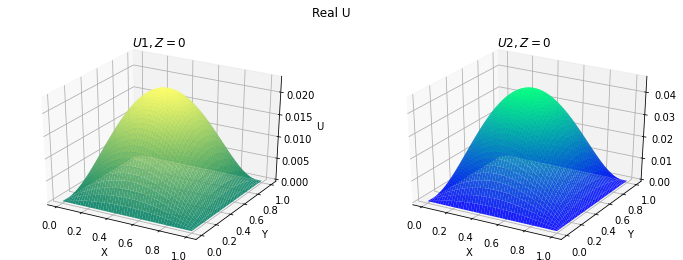

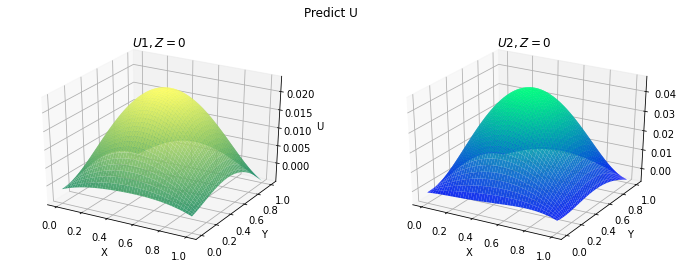

In [ ]:
U1_pred = pred_data(X_u1,Y_u1,Z_u1,T_u1,model_u1)
U2_pred = pred_data(X_u2,Y_u2,Z_u2,T_u2,model_u2)
####################################################
fig1=plt.figure(figsize=(12, 4)) 
fig1.suptitle("Real U")
ax11 = fig1.add_subplot(121,projection='3d')
ax11.plot_surface(X_u1[:,:,0],Y_u1[:,:,0],U1[:,:,0],alpha=0.9,cmap='summer') #alpha调节透明度，cmap调节曲面色调
ax12 = fig1.add_subplot(122,projection='3d')
ax12.plot_surface(X_u2[:,:,-1],Y_u2[:,:,-1],U2[:,:,-1],alpha=0.9,cmap='winter')

ax11.set_xlabel("X")   
ax11.set_ylabel("Y")
ax11.set_zlabel("U")
ax11.set_title("$U1,Z=0$")

ax12.set_xlabel("X")   
ax12.set_ylabel("Y")
ax12.set_zlabel("U")
ax12.set_title("$U2,Z=0$")
###################################################### 
fig2 = plt.figure(figsize=(12, 4)) 
fig2.suptitle("Predict U")
ax21 = fig2.add_subplot(121,projection="3d")
ax22 = fig2.add_subplot(122,projection="3d")

### u1
ax21.plot_surface(X_u1[:,:,0],Y_u1[:,:,0],U1_pred[:,:,0],alpha=0.9,cmap='summer')
ax21.set_xlabel("X")   
ax21.set_ylabel("Y")
ax21.set_zlabel("U")
ax21.set_title("$U1,Z=0$")

### u2
ax22.plot_surface(X_u2[:,:,-1],Y_u2[:,:,-1],U2_pred[:,:,-1],alpha=0.9,cmap='winter')

ax22.set_xlabel("X")   
ax22.set_ylabel("Y")
ax22.set_zlabel("U")
ax22.set_title("$U2,Z=0$")
###############################
plt.show()

In [ ]:
u1_real = U1.numpy().flatten()
u1_pred = U1_pred.numpy().flatten()
u2_real = U2.numpy().flatten()
u2_pred = U2_pred.numpy().flatten()

error_u1 = np.linalg.norm((u1_real-u1_pred),2)/np.linalg.norm(u1_real,2)  
print('Test Error For u1:  %.5f'  % (error_u1))

error_u2 = np.linalg.norm((u2_real-u2_pred),2)/np.linalg.norm(u2_real,2)  
print('Test Error For u2:  %.5f'  % (error_u2))

Test Error For u1:  0.11726
Test Error For u2:  0.07272
